## Image Segmentation with Waterched, MeanShift, Grabcut and FloodFill algorithms.

In [1]:
import cv2
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from math import exp
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations,combinations_with_replacement
import scipy
from sklearn.cluster import MeanShift, estimate_bandwidth
from skimage import data, filters
from skimage.segmentation import flood, flood_fill
%matplotlib inline

In [2]:
image1 = cv2.imread('/home/user/Downloads/3_бактерии.jpg')
image2 = cv2.imread('/home/user/Downloads/3_бактерии2.jpg')
gray1=cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
gray2=cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
gray1=cv2.cvtColor(gray1, cv2.COLOR_RGB2GRAY)
gray2=cv2.cvtColor(gray2, cv2.COLOR_RGB2GRAY)

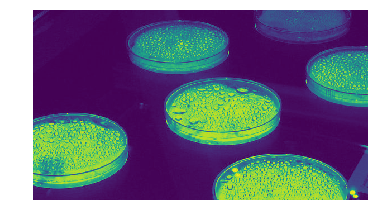

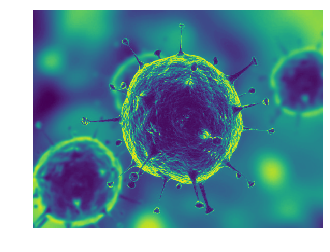

In [35]:
plt.imshow(gray1)
plt.axis("off")
plt.show()
plt.imshow(gray2)
plt.axis("off")
plt.show()

In [5]:
#xie-beni index calculation
#otherwise that is not a suitable metric for image segmentation
def sum_pairwise_manhatten_distances(A, B):
    return np.sum(scipy.spatial.distance.cdist(A, B, 'cityblock'))
def xie_beni_index(labels):
    diff_clust_sum = float()
    inner_clust_sum = float()
    combs =combinations_with_replacement(labels.label.unique(), 2)
    for item in combs:
        cl_points1 = np.asarray(list(labels[labels['label']==item[0]]['pixel'].values), dtype=np.uint8)
        cl_points2 = np.asarray(list(labels[labels['label']==item[1]]['pixel'].values), dtype=np.uint8)
        if item[0]!=item[1]:
            diff_clust_sum+=sum_pairwise_manhatten_distances(cl_points1[:20000], cl_points2[:20000])
        else:
            inner_clust_sum+=sum_pairwise_manhatten_distances(cl_points1[:20000], cl_points2[:20000])
    return inner_clust_sum/diff_clust_sum

In [7]:
#references: https://docs.opencv.org/3.3.1/d3/db4/tutorial_py_watershed.html

def watershed_segmentation(image):
    gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    plt.figure(figsize=(12,10))
    plt.axis('off')
    plt.imshow(thresh)
    plt.show()
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
    ret, sure_fg = cv2.threshold(dist_transform,0.05*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    image_copy=image.copy()
    markers = cv2.watershed(image_copy,markers)
    image_copy[markers == -1] = [255,0,0]
    plt.figure(figsize=(12,10))
    plt.axis('off')
    plt.imshow(image_copy)
    plt.show()
    return markers

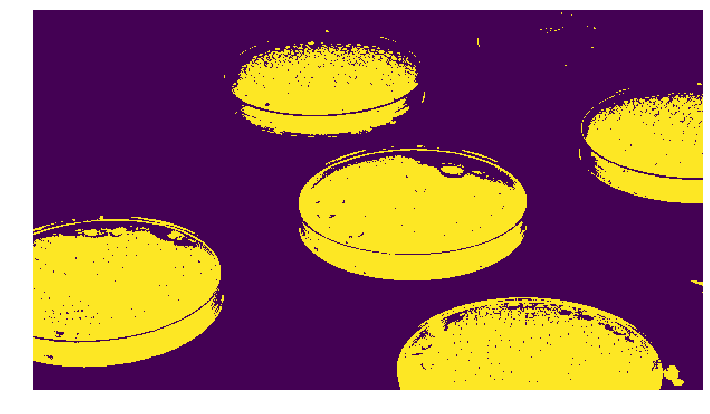

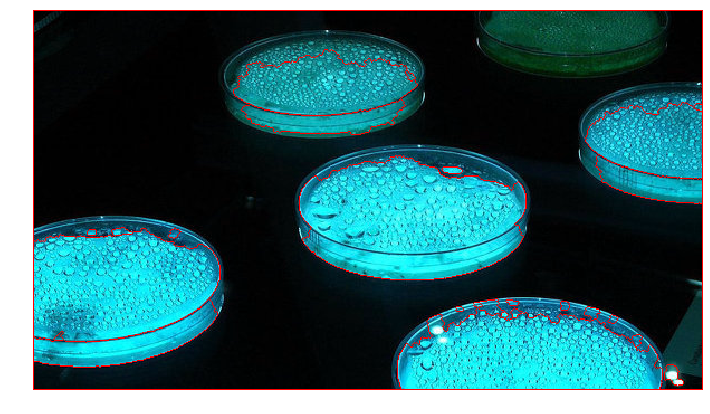

Xie-Beni index value: 0.136


In [8]:
markers = watershed_segmentation(image1)
markers = np.reshape(markers, (-1,1))
im1_matrix = np.reshape(image1, (-1,3))
labels = pd.DataFrame(columns=['label', 'pixel'])
labels['label']=markers.flatten().tolist()
labels['pixel'] = im1_matrix.tolist()
print('Xie-Beni index value: %.3f'%xie_beni_index(labels=labels))

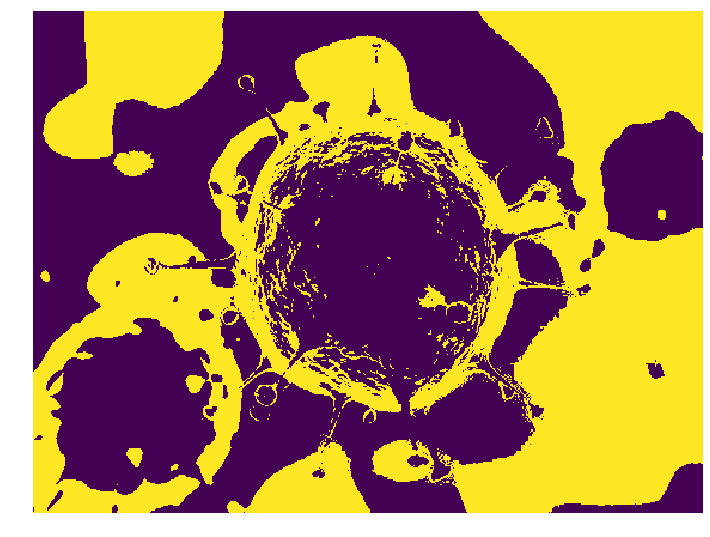

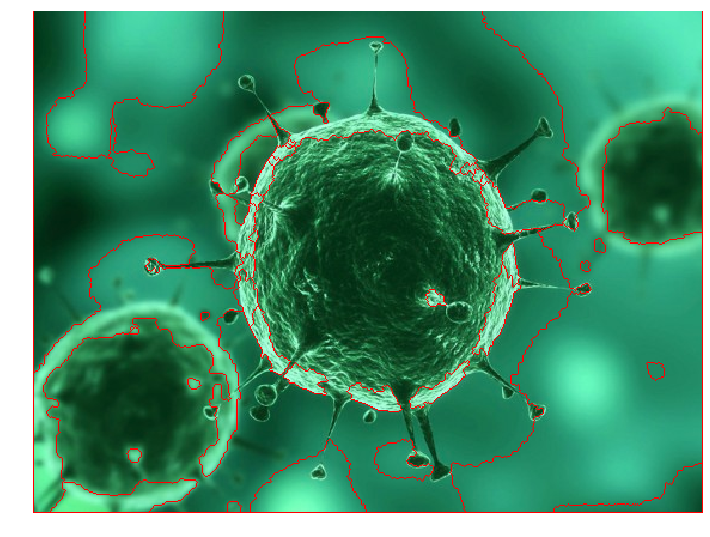

Xie-Beni index value: 0.169


In [10]:
markers = watershed_segmentation(image2)
markers = np.reshape(markers, (-1,1))
im2_matrix = np.reshape(image2, (-1,3))
labels = pd.DataFrame(columns=['label', 'pixel'])
labels['label']=markers.flatten().tolist()
labels['pixel'] = im2_matrix.tolist()
print('Xie-Beni index value: %.3f'%xie_beni_index(labels=labels))

In [9]:
def mean_shift(image):
    im_matrix = np.reshape(image, [-1,3])
    bandwidth = estimate_bandwidth(im_matrix, quantile=0.1, n_samples=100)
    print('Bandwidth: %.2f'%bandwidth)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(im_matrix)
    labels=ms.labels_
    segmented_image = np.reshape(labels, image.shape[:2])
    plt.figure(figsize=(12,10))
    plt.imshow(segmented_image)
    plt.axis('off')
    plt.show()
    return labels, im_matrix

Bandwidth: 22.04


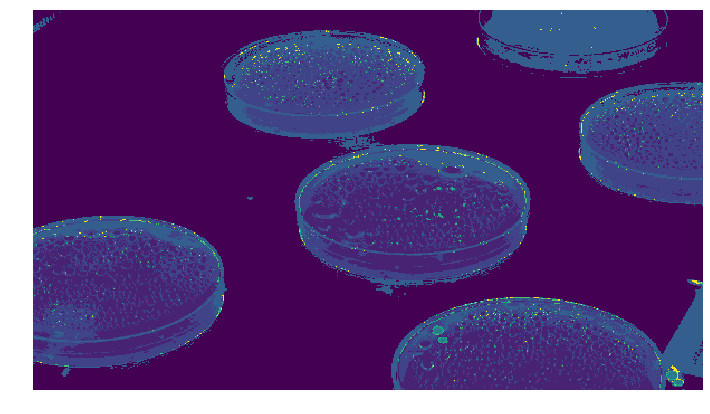

Xie-Beni index value: 0.115


In [10]:
label, mat = mean_shift(image1)
labels = pd.DataFrame(columns=['label', 'pixel'])
labels['label']=label
labels['pixel'] = mat.tolist()
print('Xie-Beni index value: %.3f'%xie_beni_index(labels=labels))

Bandwidth: 17.58


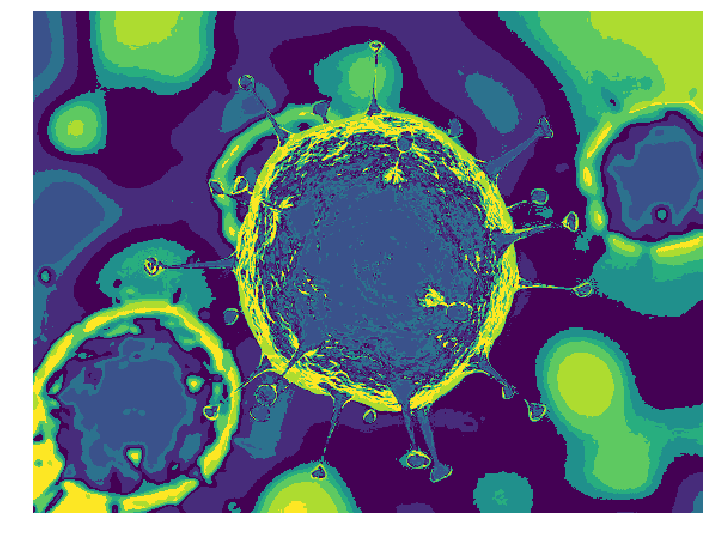

Xie-Beni index value: 0.044


In [13]:
label, mat = mean_shift(image2)
labels = pd.DataFrame(columns=['label', 'pixel'])
labels['label']=label
labels['pixel'] = mat.tolist()
print('Xie-Beni index value: %.3f'%xie_beni_index(labels=labels))

In [11]:
def grabcut_segmentation(image, rect):
    mask = np.zeros(image.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    rect = rect
    cv2.grabCut(image,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = image*mask2[:,:,np.newaxis]
    plt.figure(figsize=(12,10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return mask2

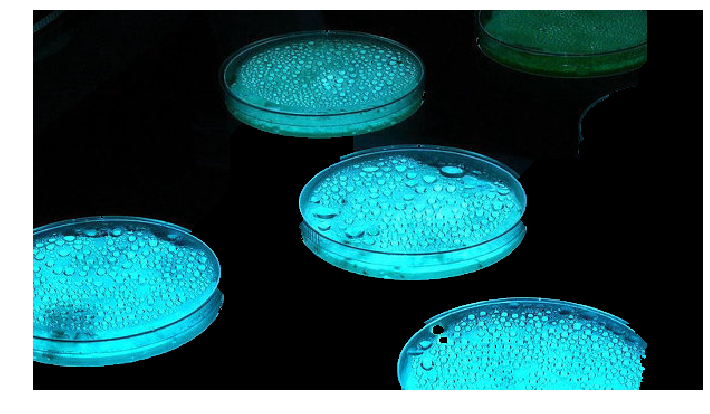

Xie-Beni index value: 1.597


In [24]:
#use appropriate rectangular
mask = grabcut_segmentation(image=image1, rect=(0,0,550,370))
mask = np.reshape(mask, (-1,1))
im1_matrix = np.reshape(image1, (-1,3))
labels = pd.DataFrame(columns=['label', 'pixel'])
labels['label']=mask.flatten().tolist()
labels['pixel'] = im1_matrix.tolist()
print('Xie-Beni index value: %.3f'%xie_beni_index(labels=labels))

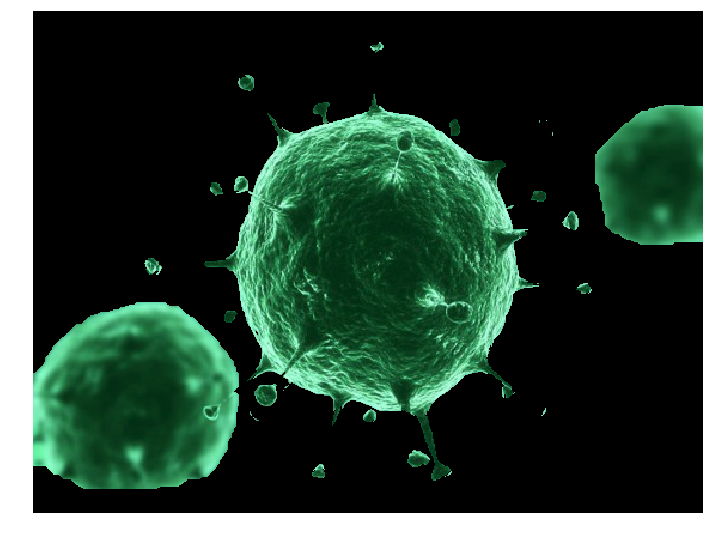

Xie-Beni index value: 1.804


In [17]:
mask = grabcut_segmentation(image=image2, rect=(0,0,600,400))
mask = np.reshape(mask, (-1,1))
im2_matrix = np.reshape(image2, (-1,3))
labels = pd.DataFrame(columns=['label', 'pixel'])
labels['label']=mask.flatten().tolist()
labels['pixel'] = im2_matrix.tolist()
print('Xie-Beni index value: %.3f'%xie_beni_index(labels=labels))

In [32]:
def flood_fill(image: np.ndarray, tolerance: float):
    sobel = filters.sobel(image[..., 0])
    mask = flood(sobel, (0, 0), tolerance=tolerance)
    return mask

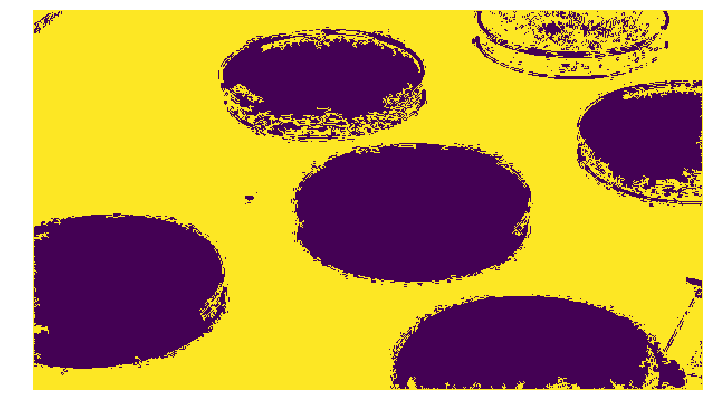

Xie-Beni index value: 0.898


In [33]:
mask = flood_fill(image1, tolerance = 0.03)
plt.figure(figsize=(12,10))
plt.imshow(mask)
plt.axis('off')
plt.show()
mask = np.reshape(mask, (-1,1))
im1_matrix = np.reshape(image1, (-1,3))
labels = pd.DataFrame(columns=['label', 'pixel'])
labels['label']=[1 if x==True else 0 for x in mask.flatten().tolist()]
labels['pixel'] = im1_matrix.tolist()
print('Xie-Beni index value: %.3f'%xie_beni_index(labels=labels))

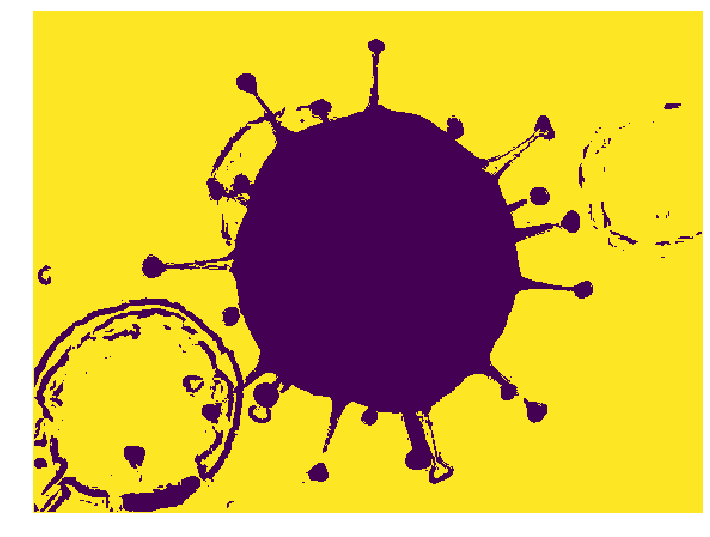

Xie-Beni index value: 1.881


In [34]:
mask = flood_fill(image2, tolerance = 0.04)
plt.figure(figsize=(12,10))
plt.imshow(mask)
plt.axis('off')
plt.show()
mask = np.reshape(mask, (-1,1))
im1_matrix = np.reshape(image2, (-1,3))
labels = pd.DataFrame(columns=['label', 'pixel'])
labels['label']=[1 if x==True else 0 for x in mask.flatten().tolist()]
labels['pixel'] = im1_matrix.tolist()
print('Xie-Beni index value: %.3f'%xie_beni_index(labels=labels))

## Summary
The best algorithms was grabcut and floodfill algorithms. MeanShift is clustering algorithms, so in this case it solve color quantization problem, but not image segmentation.